
# Step 5 — Hyperparameter Tuning (on engineered features)

We'll tune **Random Forest** and **Logistic Regression** using the engineered dataset
`telco_churn_features.csv` created earlier.

**What this notebook does**
1. Load engineered data
2. Train/test split (stratified)
3. Preprocess (OneHot for categoricals, StandardScaler for numerics)
4. **RandomizedSearchCV** for Random Forest (optimize ROC-AUC)
5. **GridSearchCV** for Logistic Regression (optimize ROC-AUC)
6. Evaluate both best models on the test set (classification report, ROC-AUC, confusion matrix & ROC curve)


In [1]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from scipy.stats import randint, uniform

# Load engineered dataset
df = pd.read_csv("telco_churn_features.csv")
print("Shape:", df.shape)
assert 'Churn' in df.columns, "Expected 'Churn' column."

# Target & features
y = (df['Churn'] == 'Yes').astype(int) if df['Churn'].dtype == object else df['Churn']
X = df.drop(columns=[c for c in ['Churn','customerID'] if c in df.columns])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Column selectors
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Shape: (500, 25)


## Random Forest — RandomizedSearchCV (scoring = ROC-AUC)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best RF params: {'rf__class_weight': 'balanced', 'rf__max_depth': 4, 'rf__max_features': None, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 8, 'rf__n_estimators': 220}
Best RF CV AUC: 0.502

--- Random Forest (best) on test ---
              precision    recall  f1-score   support

           0      0.531     0.510     0.520        51
           1      0.510     0.531     0.520        49

    accuracy                          0.520       100
   macro avg      0.520     0.520     0.520       100
weighted avg      0.520     0.520     0.520       100

Test ROC-AUC: 0.539


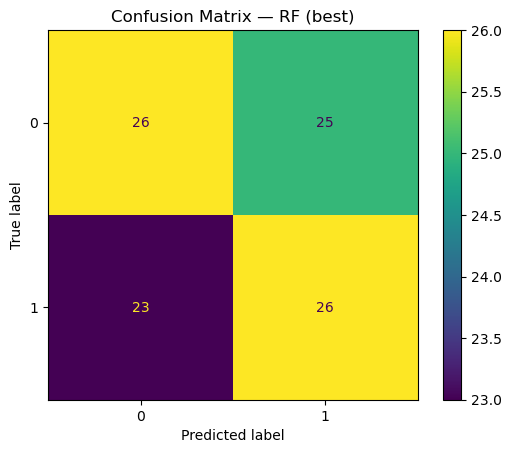

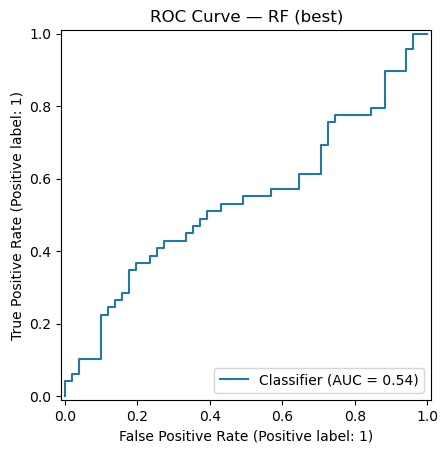

In [2]:

rf_pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_param_dist = {
    'rf__n_estimators': randint(200, 800),
    'rf__max_depth': [None] + list(range(3, 20)),
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 10),
    'rf__max_features': ['sqrt', 'log2', 0.5, 0.7, None],
    'rf__class_weight': [None, 'balanced']
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    rf_param_dist,
    n_iter=40,
    scoring='roc_auc',
    cv=cv,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)
print("Best RF CV AUC:", round(rf_search.best_score_, 3))

# Evaluate on test set
rf_best = rf_search.best_estimator_
y_pred = rf_best.predict(X_test)
y_prob = rf_best.predict_proba(X_test)[:, 1]

print("\n--- Random Forest (best) on test ---")
print(classification_report(y_test, y_pred, digits=3))
print("Test ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix — RF (best)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — RF (best)")
plt.show()


## Logistic Regression — GridSearchCV (scoring = ROC-AUC)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best LogReg params: {'log__C': 0.5, 'log__class_weight': None, 'log__penalty': 'l1'}
Best LogReg CV AUC: 0.513

--- Logistic Regression (best) on test ---
              precision    recall  f1-score   support

           0      0.500     0.510     0.505        51
           1      0.479     0.469     0.474        49

    accuracy                          0.490       100
   macro avg      0.490     0.490     0.490       100
weighted avg      0.490     0.490     0.490       100

Test ROC-AUC: 0.481


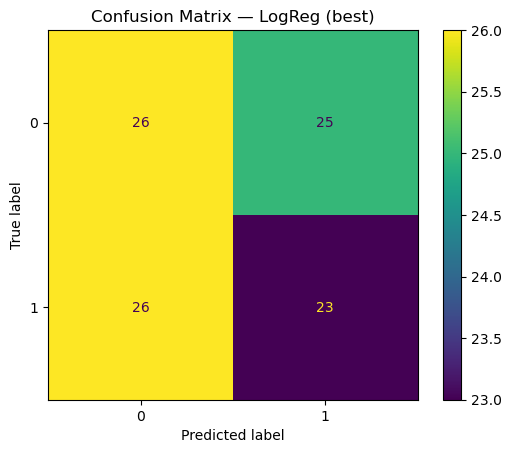

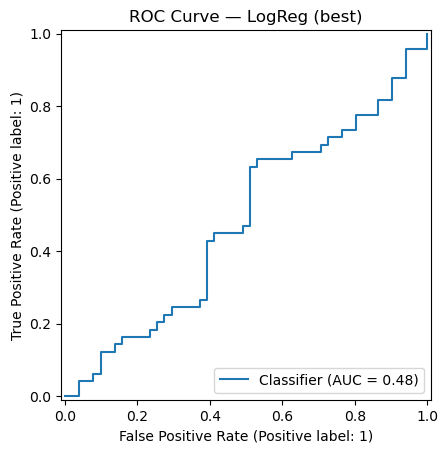

In [3]:

log_pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('log', LogisticRegression(max_iter=2000, solver='liblinear', random_state=42))
])

log_param_grid = {
    'log__C': [0.01, 0.1, 0.5, 1, 2, 5, 10],
    'log__penalty': ['l1', 'l2'],
    'log__class_weight': [None, 'balanced']
}

log_search = GridSearchCV(
    log_pipe,
    log_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

log_search.fit(X_train, y_train)
print("Best LogReg params:", log_search.best_params_)
print("Best LogReg CV AUC:", round(log_search.best_score_, 3))

# Evaluate on test set
log_best = log_search.best_estimator_
y_pred = log_best.predict(X_test)
y_prob = log_best.predict_proba(X_test)[:, 1]

print("\n--- Logistic Regression (best) on test ---")
print(classification_report(y_test, y_pred, digits=3))
print("Test ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix — LogReg (best)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — LogReg (best)")
plt.show()


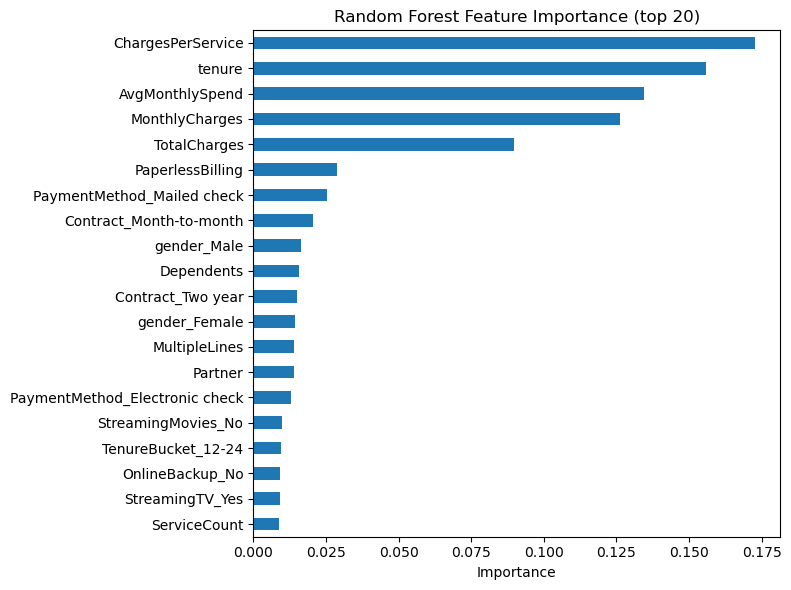

,importance
ChargesPerService,0.172646
tenure,0.155880
AvgMonthlySpend,0.134637
MonthlyCharges,0.126252
TotalCharges,0.089631
PaperlessBilling,0.028949
PaymentMethod_Mailed check,0.025348
Contract_Month-to-month,0.020531
gender_Male,0.016291
Dependents,0.015681


In [4]:
# === Step 6: Feature Importance (Random Forest) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the fitted pipeline and its parts
rf_best = rf_search.best_estimator_                     # Pipeline(prep -> rf)
prep     = rf_best.named_steps['prep']                  # ColumnTransformer
rf_model = rf_best.named_steps['rf']                    # RandomForestClassifier

# 2) Rebuild the post-transform feature names in the SAME order used by the model
#    Order in ColumnTransformer = [('cat', OneHotEncoder), ('num', StandardScaler)]
ohe = prep.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols) # e.g. Contract_Month-to-month, etc.
num_feature_names = np.array(num_cols, dtype=object)

feature_names = np.r_[cat_feature_names, num_feature_names]  # same order as the model sees

# 3) Map importances to names
importances = rf_model.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# 4) Show top features
TOP_N = 20
plt.figure(figsize=(8, 6))
fi.head(TOP_N)[::-1].plot(kind='barh')
plt.title(f"Random Forest Feature Importance (top {TOP_N})")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Optional: print a small table
fi.head(TOP_N).to_frame("importance")


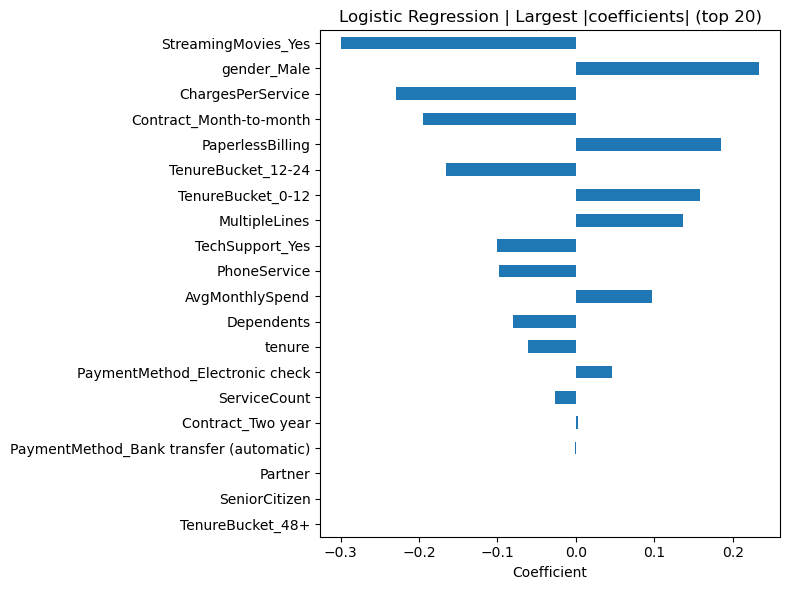

In [5]:
# (Optional) Logistic Regression coefficients
log_best = log_search.best_estimator_
prep_log = log_best.named_steps['prep']
ohe_log  = prep_log.named_transformers_['cat']
cat_names_log = ohe_log.get_feature_names_out(cat_cols)
num_names_log = np.array(num_cols, dtype=object)
log_feature_names = np.r_[cat_names_log, num_names_log]

coefs = log_best.named_steps['log'].coef_.ravel()
coef_series = pd.Series(coefs, index=log_feature_names).sort_values(key=np.abs, ascending=False)

plt.figure(figsize=(8, 6))
coef_series.head(20)[::-1].plot(kind='barh')
plt.title("Logistic Regression | Largest |coefficients| (top 20)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()